In [1]:
!pip install nixtla

In [2]:
!pip install yfinance

In [3]:
!pip install datasetsforecast

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nixtla import NixtlaClient

In [5]:
nixtla_client = NixtlaClient(api_key='nixtla-tok-2WhMO3zBSmvCWqvVBaBAH31mEBTR6YdwLdEurcwldlkVsex1JoxxKPAYYGXjvkPQxp1Ud77q5qvfCw7y')

tesla = "TSLA"
start = "2018-01-01"
end = "2023-12-15"

data = yf.download(tesla, start=start, end=end)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True) 

[*********************100%%**********************]  1 of 1 completed


In [6]:
train_data = data[(data['Date'] >= '2018-01-01') & (data['Date'] <= '2022-12-31')]
test_data = data[(data['Date'] >= '2023-01-01') & (data['Date'] <= '2023-12-15')]

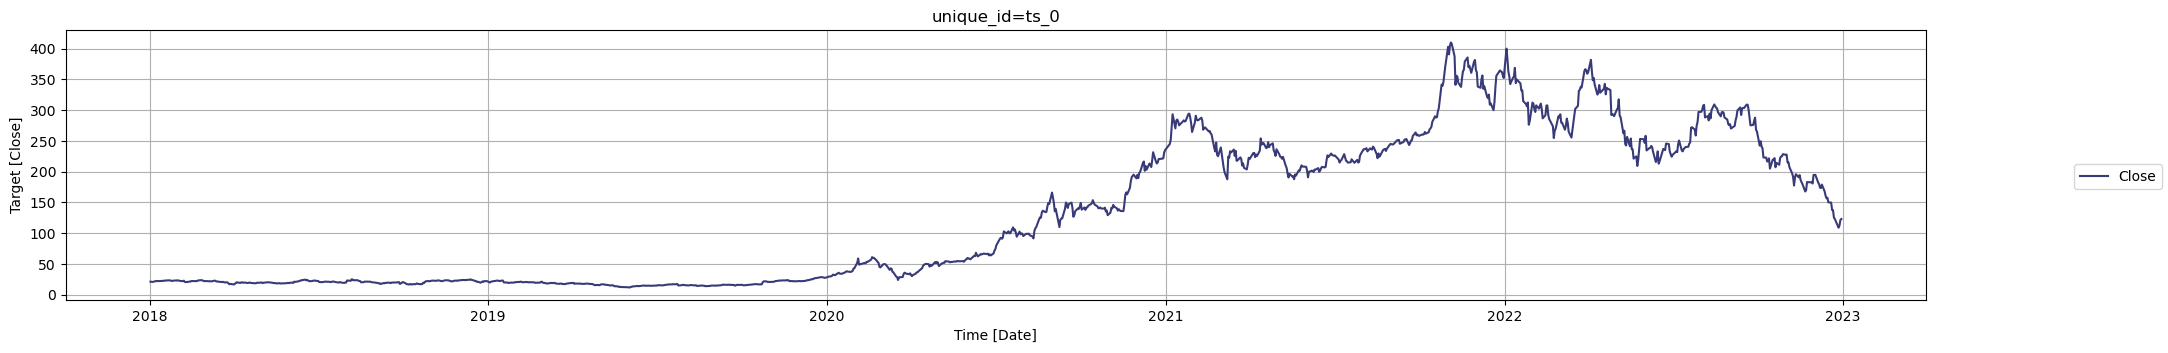

In [7]:
nixtla_client.plot(train_data, time_col='Date', target_col='Close')

In [8]:
data_forecast = nixtla_client.forecast(
    df=train_data,
    h=len(test_data),
    freq='B',
    level=[90],
    finetune_steps=10,
    model='timegpt-1-long-horizon',
    time_col='Date',
    target_col='Close'
)
data_forecast

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Date,TimeGPT,TimeGPT-lo-90,TimeGPT-hi-90
0,2023-01-02,105.637581,90.088405,121.186757
1,2023-01-03,105.805672,76.711749,134.899594
2,2023-01-04,102.778358,73.895066,131.661651
3,2023-01-05,104.627159,67.702097,141.552221
4,2023-01-06,106.034500,64.669377,147.399623
...,...,...,...,...
235,2023-11-27,245.880157,138.485933,353.274382
236,2023-11-28,253.851227,147.587389,360.115065
237,2023-11-29,251.670822,147.347846,355.993798
238,2023-11-30,249.033051,148.786699,349.279402


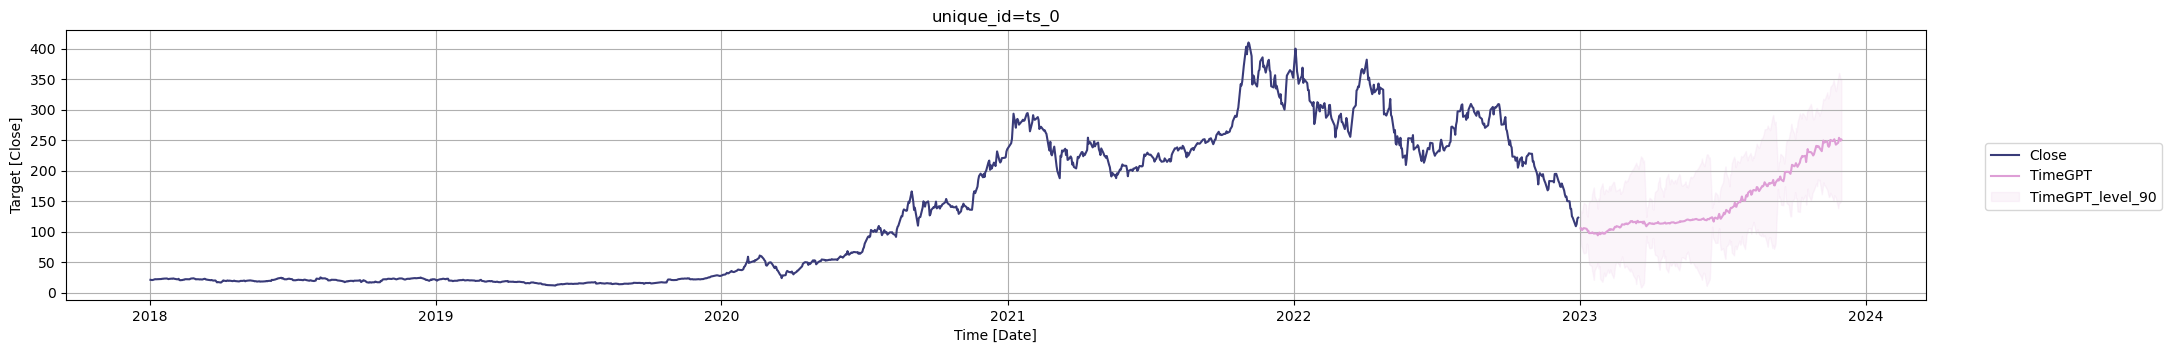

In [9]:
nixtla_client.plot(train_data, data_forecast, models=['TimeGPT'], level=[90], time_col='Date', target_col='Close')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: Open, High, Low, Adj Close, Volume


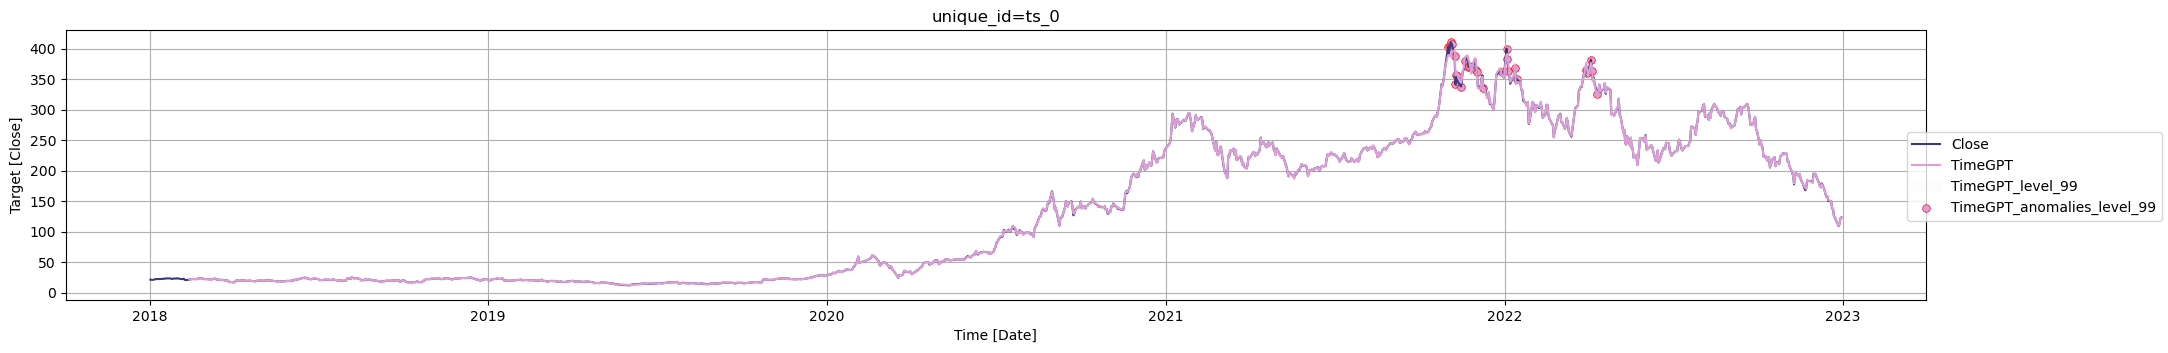

In [10]:
anomalies = nixtla_client.detect_anomalies(train_data, time_col='Date', target_col='Close', freq='B')
nixtla_client.plot(train_data, anomalies, time_col='Date', target_col='Close', plot_anomalies=True)

In [11]:
# Debugging: print the first few rows of data_forecast
print("Forecast data:")
print(data_forecast.head())

# Calculate metrics
rmse = mean_squared_error(test_data['Close'], data_forecast['TimeGPT'], squared=False)
mae = mean_absolute_error(test_data['Close'], data_forecast['TimeGPT'])

# Check for NaN values in data_forecast
if data_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the forecast data")

# Replace zero values in test_data['Close'] with NaN
test_data_non_zero = test_data.copy()
test_data_non_zero['Close'].replace(0, np.nan, inplace=True)

# Drop rows with NaN values resulting from replacement
test_data_non_zero.dropna(subset=['Close'], inplace=True)

# Ensure that the Date column is the same format
data_forecast['Date'] = pd.to_datetime(data_forecast['Date'])
test_data_non_zero['Date'] = pd.to_datetime(test_data_non_zero['Date'])

# Print the first few rows of test_data_non_zero
print("Test data non-zero:")
print(test_data_non_zero.head())

# Align forecasts with the modified test data
aligned_forecast = data_forecast[data_forecast['Date'].isin(test_data_non_zero['Date'])].copy()

# Debugging: print the first few rows of aligned_forecast
print("Aligned forecast data before setting index:")
print(aligned_forecast.head())

# Ensure the indices match
test_data_non_zero.set_index('Date', inplace=True)
aligned_forecast.set_index('Date', inplace=True)

# Debugging: print the first few rows of aligned_forecast after setting index
print("Aligned forecast data after setting index:")
print(aligned_forecast.head())

# Check again for NaN values in the aligned forecast
if aligned_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the aligned forecast data")

# Remove NaN values from aligned_forecast
aligned_forecast.dropna(subset=['TimeGPT'], inplace=True)

# Recalculate MAPE only for the dates that are present in both test_data_non_zero and aligned_forecast
common_dates = test_data_non_zero.index.intersection(aligned_forecast.index)
test_data_non_zero_common = test_data_non_zero.loc[common_dates]
aligned_forecast_common = aligned_forecast.loc[common_dates]

# Debugging: print the first few rows of the common data
print("Common test data:")
print(test_data_non_zero_common.head())
print("Common forecast data:")
print(aligned_forecast_common.head())

# Calculate MAPE
mape = np.mean(np.abs((test_data_non_zero_common['Close'].values - aligned_forecast_common['TimeGPT'].values) / test_data_non_zero_common['Close'].values)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

Forecast data:
         Date     TimeGPT  TimeGPT-lo-90  TimeGPT-hi-90
0  2023-01-02  105.637581      90.088405     121.186757
1  2023-01-03  105.805672      76.711749     134.899594
2  2023-01-04  102.778358      73.895066     131.661651
3  2023-01-05  104.627159      67.702097     141.552221
4  2023-01-06  106.034500      64.669377     147.399623
Test data non-zero:
           Date        Open        High         Low       Close   Adj Close  \
1259 2023-01-03  118.470001  118.800003  104.639999  108.099998  108.099998   
1260 2023-01-04  109.110001  114.589996  107.519997  113.639999  113.639999   
1261 2023-01-05  110.510002  111.750000  107.160004  110.339996  110.339996   
1262 2023-01-06  103.000000  114.389999  101.809998  113.059998  113.059998   
1263 2023-01-09  118.959999  123.519997  117.110001  119.769997  119.769997   

         Volume  
1259  231402800  
1260  180389000  
1261  157986300  
1262  220911100  
1263  190284000  
Aligned forecast data before setting index:
  

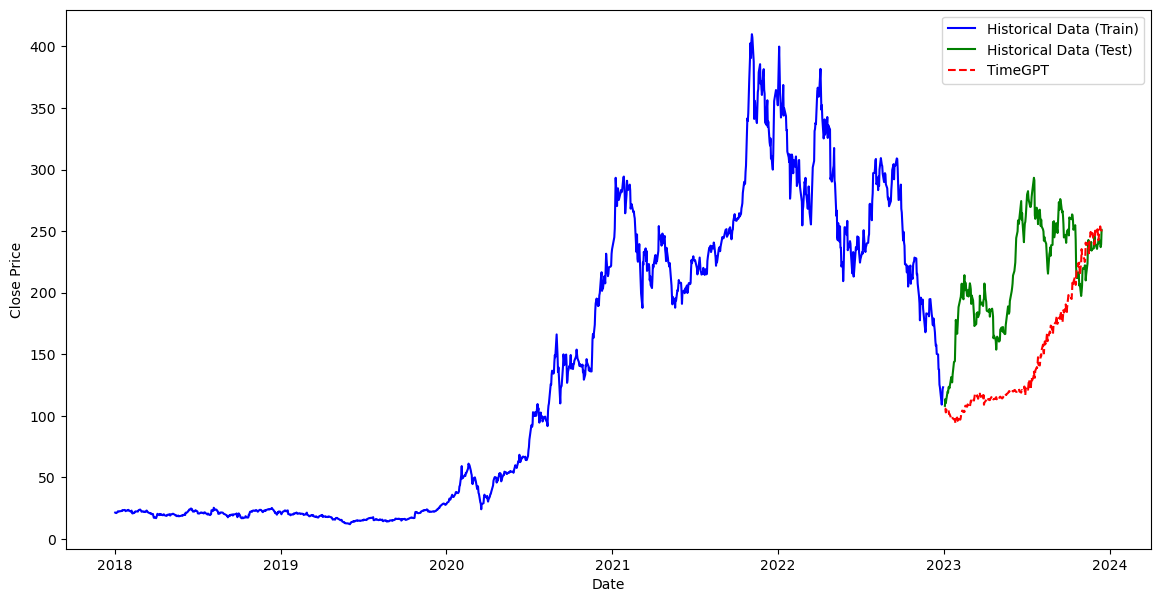

In [12]:
import matplotlib.pyplot as plt

# Визуализация на историческите данни и прогнозата
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], train_data['Close'], label='Historical Data (Train)', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Historical Data (Test)', color='green')
plt.plot(test_data['Date'], data_forecast['TimeGPT'], label='TimeGPT', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
highest_forecast_price = data_forecast['TimeGPT'].max()
lowest_forecast_price = data_forecast['TimeGPT'].min()

highest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmax()]['Date']
lowest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmin()]['Date']

print(f"Highest forecasted price: {highest_forecast_price} on {highest_forecast_date}")
print(f"Lowest forecasted price: {lowest_forecast_price} on {lowest_forecast_date}")

Highest forecasted price: 253.85122680664062 on 2018-12-10 00:00:00
Lowest forecasted price: 94.22561645507812 on 2018-01-25 00:00:00
